In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/Colab Notebooks/Research Techniques II/merged_dataset_v2.csv'

In [3]:
import pandas as pd

df = pd.read_csv(file_path, index_col = 0)
df.head()

,Unnamed: 0,text,labels
0,0,Bu tətbiq niyə nömrəyə kod göndərmirr,0
1,1,Biz evin qida məhsullarini bravodan alırıq çox...,1
2,2,Pisdir çox exlaqsizliq bas alıb gedir,0
3,3,Qulag asmiram amma merifetli qardasdi Allah ca...,1
4,4,m10 kimi rahat gözəl tətbiq yoxdur,1


In [7]:
print(df.columns)


Index(['Unnamed: 0', 'text', 'labels'], dtype='object')


In [8]:
df['labels'].value_counts()

,count
labels,
1,32832
0,22841


In [4]:
from sentence_transformers import SentenceTransformer

# LaBSE modelini yükle
model = SentenceTransformer('sentence-transformers/LaBSE')

# Temizlenmiş metinleri al
texts = df['text'].tolist()

# Embedding çıkar (batch size isteğe göre artırılabilir)
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/870 [00:00<?, ?it/s]

In [7]:
import numpy as np

# NumPy array'e dönüştürmek istiyorsan:
embeddings = np.array(embeddings)

# Şekli kontrol et (satır sayısı, embedding boyutu)
print(embeddings.shape)

(55673, 768)


In [9]:
X_seq = np.expand_dims(embeddings, axis=1)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq,
    df['labels'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['labels'].values  # mutlaka kalmalı
)

In [12]:
X_train = X_train.squeeze(axis=1)
X_test = X_test.squeeze(axis=1)

In [13]:
import lightgbm as lgb

clf = lgb.LGBMClassifier(
    n_jobs=-1,
    verbosity=1  # veya 'verbose': 1
)

clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26265, number of negative: 18273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 44538, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.589721 -> initscore=0.362813
[LightGBM] [Info] Start training from score 0.362813


LGBMClassifier(n_jobs=-1, verbosity=1)

              precision    recall  f1-score   support

    negative       0.76      0.80      0.78      4568
    positive       0.86      0.82      0.84      6567

    accuracy                           0.82     11135
   macro avg       0.81      0.81      0.81     11135
weighted avg       0.82      0.82      0.82     11135

Confusion Matrix:
[[3663  905]
 [1154 5413]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


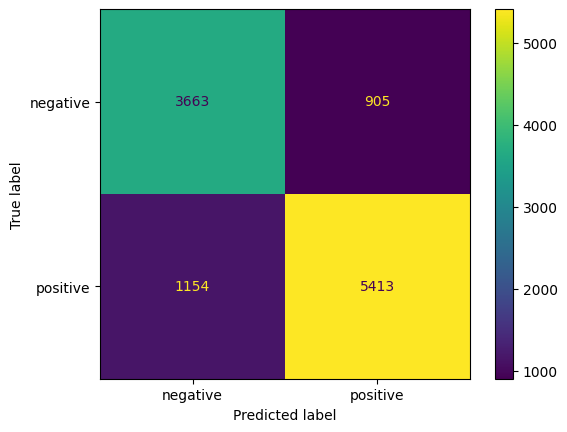

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Test verisi için tahmin yap
y_pred = clf.predict(X_test)

# Sınıf isimlerini manuel olarak belirle (çünkü 0 ve 1 string değil)
target_names = ["negative", "positive"]

# Sınıflandırma raporu
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix yazdır
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Opsiyonel: Confusion matrix görselleştirme
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()